**Preparing the pest files for the Cas5_I_E - SEB without snow - monthly data for all datasets except precipitation (actual data is given)**

* The notebook is developed to code the methodology and extract relevant files that are suitable as input to PEST.
- pestpp/pestpp/benchmarks/mf6_freyberg - This is used as the standard benchmark folder from which the files are referred.
- Currently, the freyberg6_run_glm.pst which solves the Levenberg - Marquardt algorithm is considered.

Parameters considered: 'alpha_p_gp', 'alpha_m_gp', 'n_p_gp', 'n_m_gp', 'wr_p_gp', 'wr_m_gp', 'tcs_p_gp', 'tcs_m_gp', 'tcd_p_gp', 'tcd_m_gp', 'af_p_gp', 'af_m_gp', 'auf_p_gp', 'auf_m_gp', 'por_p_gp', 'por_m_gp', 'perm_p_gp', 'perm_m_gp', 'den_p_gp', 'den_m_gp'

The surface parameters which are important [Surfaces: bg - bare ground, s - snow, w - water]: - Reference - Atchley 2015 article] - albedo_bg, e_bg, pen_w, pen_bg, z_bg, z_s.

**Since we are currently considering SEB without snow, we can neglect - z_s, Still considering it as to see if it really has an influence**

    * 'albedo_bg': Albedo of the bare surface. [ Expected value = 0.8 (On backcalculating the albedo from incoming and outgoing shortwave radiation, during the summer = 0.8), Considering it to vary by 75 % also.]. It's importance is observed when we are calculating the outgoing shortwave radiation component. Initial value = 0.55. 
    
    * Can we change the albedo of water, and snow?
    
    * 'e_bg': Emissivity of the bare surface. It is used to calculate the outgoing longwave radiation. [Expected value = 0.92 from lit. Atchley 2015]. Assuming an initial value = 0.55 and lower and upper bound is +-75% of initial value. 
    
    * Can we change the emissivity of water, and snow?
    
    * 'pen_w': Penetration depth of shortwave radiation in water. It influences the calculation of transition_albedo.  Initial value = 0.01 m. 
    
    * 'pen_s':  Penetration depth of shortwave radiation in snow. It influences the calculation of transition_albedo. Initial value = 0.02 m.
    
    * 'z_bg': Roughness length of bare ground [m]. It influences the calculation of turbulence terms of latent and sensible heat. Initial value = 0.04 m [For polygonal tundra]. 
    
    * 'z_s': Roughness length of snow [m]. It influences the calculation of turbulence terms of latent and sensible heat. Initial value = 0.005 m [For wind swept snow].



- We are considering the initial parameters based on the simulation : all_params_afterrw.demo

- The lower and upper bound is fixed to 75 % of the initial value

- Some values that do not accept these changes, have been changed with respect to their initial value


TODO:
- Template files
- Instruction files
- Output files from ATS (observation.dat) - How to hint PEST about these instruction files?
- Input file (input.xml) how do we change the parameter here as per the template file?

* Develop a methodology and write here!



In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/rk/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
%matplotlib inline
import sys,os
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pandas as pd
from datetime import datetime
import matplotlib.image as mpimg

In [6]:
import shutil
import numpy as np
import pandas as pd
import pyemu
import flopy
import subprocess

In [3]:
directory_name = 'Case5_I_E_glm_start.demo'
file_name = 'Case5_I_E_glm'

In [7]:
# Making the directory with the given name
os.mkdir(directory_name)

In [7]:
# Changing into the directory
os.chdir(directory_name)

/home/rk/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final/Case5_I_E_glm_start.demo'

### Observation - data

#### The data was preprocessed in another folder - 

In [10]:
filename_mes = '../Yakou_data_processed_2017.csv'

In [12]:
yakou_data =  pd.read_csv(filename_mes)
yakou_data.head()

,TIMESTAMP,Wind speed at 10 m (m/s),Wind direction at 10 m (°),Air temperature at 5 m (°C),Relative humidity at 5 m (%),Precipitation at 10 m (mm),Air pressure (hPa),Infrared temperature (°C),Infrared temperature (°C).1,PAR_down,...,Soil temperature at - 0.4 m (°C),Soil temperature at - 0.8 m (°C),Soil temperature at - 1.2 m (°C),Soil temperature at - 1.6 m (°C),Soil temperature at - 0.04 m (K),Soil temperature at - 0.2 m (K),Soil temperature at - 0.4 m (K),Soil temperature at - 0.8 m (K),Soil temperature at - 1.2 m (K),Soil temperature at - 1.6 m (K)
0,2017-01-01,5.703646,240.315972,-11.643319,26.417292,0.0,609.727778,-13.595701,-13.473771,23.526389,...,-9.902153,-8.312083,-5.657743,-4.284076,261.023264,262.172222,263.247847,264.837917,267.492257,268.865924
1,2017-01-02,4.522028,215.252083,-12.547639,25.603264,0.0,611.459722,-14.148368,-14.069958,23.598458,...,-9.815208,-8.296667,-5.790653,-4.451597,261.006667,262.246458,263.334792,264.853333,267.359347,268.698403
2,2017-01-03,5.572090,211.012500,-12.374722,43.428264,0.0,609.315278,-14.089813,-14.027125,18.449590,...,-9.805000,-8.309931,-5.898486,-4.594007,260.854861,262.184583,263.345000,264.840069,267.251514,268.555993
3,2017-01-04,6.037000,242.357639,-10.819882,30.436111,0.0,608.171528,-13.654188,-13.519576,24.310958,...,-9.844306,-8.356181,-5.995306,-4.716979,261.032708,262.226806,263.305694,264.793819,267.154694,268.433021
4,2017-01-05,5.978368,196.270833,-10.152083,22.180000,0.0,607.352778,-13.348424,-13.196604,24.258903,...,-9.785764,-8.384167,-6.089104,-4.832729,261.347014,262.409792,263.364236,264.765833,267.060896,268.317271


#### Accessing data - from simulations:

In [14]:
sim_data = pd.read_csv('../rk_model_glm_obs_data.dat', sep=' ')
sim_data['point -0.04 saturation liquid'].describe()

count    366.000000
mean       0.298824
std        0.273229
min        0.106138
25%        0.107801
50%        0.110564
75%        0.703625
max        0.713422
Name: point -0.04 saturation liquid, dtype: float64

### 1. Parameter groups external
- Extracting the data from the example

In [16]:
pargrp_data_example = pd.read_csv('../Freyberg_example/freyberg6_run_glm.pargrp_data.csv') 
pargrp_data_example.head()

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd,splitthresh,splitreldiff,splitaction
0,sto_ss_0,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
1,npf_k33_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
2,npf_k_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
3,sto_ss_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
4,npf_k_0,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller


#### Defining the variables in Parameter Group variables: 
- PARGPNME : Individual groups assigned for all parameters! - Assigned a total of 20 parameters (10 for each material)
- INCTYP : 'relative' - The increment used for forward-difference calculation of derivatives with respect to any parameter belonging to the group is calculated as the fraction of the current value of that parameter; that fraction is provided as the real variable DERINC. Ex: If current value of parameter = 10 & DERINC =  0.01. Then the next parameter value = 0.01 * 10 = 0.1.
- DERINC : '0.01' - The fraction of increment of the current value of parameter. [Consider the range of variation of the parameters, upper and lower bounds]
- DERINCLB : '0.0'
- FORCEN : 'switch'. In the first iteration, forward difference method is employed. From the second iteration, it switches to central difference method for the remainder of the inversion process on the iteration after which the relative objective function reduction between successive iterations is less than PHIREDSWH. Note we need to define PHIREDSWH (Where is it defined in this format?)
- DERINCMUL : '1.0' - If three-point derivatives calculation is employed, the value of DERINC is multiplied by DERINCMUL.
- DERMTHD : 'parabolic' - This is preferred as it provides greater accuracy.
- [SPLITTHRESH] [SPLITRELDIFF] [SPLITACTION] - For the first analysis, we ignore the three variables.

In [55]:
pargrp = pargrp_data_example.copy()
# Dropping all rows to replace with the two newly defined rows
pargrp.drop(pargrp.index, inplace=True)
# Dropping the columns - splitthresh, splitreldiff, splitaction
pargrp.drop(columns=['splitthresh', 'splitreldiff', 'splitaction'], inplace=True)

group_names = ['alpha_p_gp', 'alpha_m_gp', 'n_p_gp', 'n_m_gp', 'wr_p_gp', 'wr_m_gp', 'tcs_p_gp', 'tcs_m_gp', 'tcd_p_gp', 'tcd_m_gp', 'af_p_gp', 'af_m_gp', 'auf_p_gp', 'auf_m_gp', 'por_p_gp', 'por_m_gp', 'perm_p_gp', 'perm_m_gp', 'den_p_gp', 'den_m_gp','albedo_bg_gp','e_bg_gp','pen_w_gp','pen_s_gp','z_bg_gp','z_s_gp']

for i, gp_nm in enumerate(group_names):
    pargrp.loc[i] = [gp_nm, 'relative',0.1,0.0,'switch',1.0,'parabolic']
    #print(i, gp_nm)
    
pargrp

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd
0,alpha_p_gp,relative,0.1,0.0,switch,1.0,parabolic
1,alpha_m_gp,relative,0.1,0.0,switch,1.0,parabolic
2,n_p_gp,relative,0.1,0.0,switch,1.0,parabolic
3,n_m_gp,relative,0.1,0.0,switch,1.0,parabolic
4,wr_p_gp,relative,0.1,0.0,switch,1.0,parabolic
5,wr_m_gp,relative,0.1,0.0,switch,1.0,parabolic
6,tcs_p_gp,relative,0.1,0.0,switch,1.0,parabolic
7,tcs_m_gp,relative,0.1,0.0,switch,1.0,parabolic
8,tcd_p_gp,relative,0.1,0.0,switch,1.0,parabolic
9,tcd_m_gp,relative,0.1,0.0,switch,1.0,parabolic


In [56]:
directory_name

'Case5_I_E_glm_start.demo'

In [57]:
file_name

'Case5_I_E_glm'

In [58]:
# Exporting the parameter group csv file
pargrp.to_csv(f'{file_name}_pargrp_data.csv', index=False)

### 1. Parameter names external
There are 26 parameters that we are considering for this first analysis

In [59]:
par_data_example = pd.read_csv('../Freyberg_example/freyberg6_run_glm.par_data.csv') 
par_data_example.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,partied
0,npf_k33_0_000_000,log,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,NaN
1,npf_k33_0_000_001,tied,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
2,npf_k33_0_000_002,tied,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
3,npf_k33_0_000_003,tied,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
4,npf_k33_0_000_004,tied,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000


The following details need to be defined:
- PARNME: 'n_m', 'tcs_m', 'af_m', 'af_p', .... - It is the parameter name
- PARTRANS: 'none' {'log' - Can we considered later if the inversion process does not occur. Log-transformations helps in ensuring that the parameter changes and model output changes are more linear.}
- PARCHGLIM: 'factor' - Alteration to a parameter's value is factor-limited. { PARCHGLIM must be provided with a value of “relative” or “factor”. The former designates that alterations to a parameter’s value are factor-limited whereas the latter designates that alterations to its value are relative-limited. }
- PARVALI: 1.2, 1, 0.05, 0.005 - These are the starting values for the parameters
- PARLBND: 1.05, 0.8, 0.02, 0.002 - Lower bounds for the parameters.
- PARUBND: 3, 2.5, 0.1, 0.01 - Upper bounds for the parameters.
- PARGRP: 'hydraulic','thermal','hydraulic', 'hydraulic' - It is the parameter group names associated with the parameters. 
- SCALE: 1.0, 1.0, 1.0, 1.0 - No scale or offset is provided
- OFFSET: 0.0, 0.0, 0.0, 0.0 - No scale or offset is provided
- DERCOM: 1, 1, 1, 1 - Only model command exists. Hence we give 1 which represents 'ats'
- Partied: This column will be dropped since we have no tied elements

In [60]:
# Getting the best parameter dataset from the simulation - all_params_afterrw.demo
directory_name_params = 'all_params_afterrw.demo'
best_params_afterrw = pd.read_csv(f'../{directory_name_params}/rk_model_glm_cf_v1_allparams_rw.par',delimiter='\s+',skiprows=1, header=None)
best_params_afterrw.drop(columns=[2,3],inplace=True)
best_params_afterrw.columns = ['parameter','PARVAL1']
best_params_afterrw.head()



length_index = len(best_params_afterrw.index)


best_params_afterrw.index = best_params_afterrw['parameter']
best_params_afterrw.drop(columns='parameter',inplace=True)


# Changing the initial value of n_p, n_m and den_m
best_params_afterrw.loc['n_p'] = 2.05 # Since value below 1.05 is not allowed
best_params_afterrw.loc['n_m'] = 2.05 # Since value below 1.05 is not allowed
best_params_afterrw.loc['den_m'] = 1900 # Since value above 2700 represents a soil mineral layer

#best_params_afterrw.loc['perm_p'] = 5.346622127220000e-11

# Changing to float type 
best_params_afterrw = best_params_afterrw.astype('float64')

# Adding the lower and upper bound - 75% for all params except n_p, n_m and den_m which is given 50 %
best_params_afterrw['PARLBND'] = best_params_afterrw['PARVAL1']*0.25
best_params_afterrw['PARUBND'] = best_params_afterrw['PARVAL1']*1.75

best_params_afterrw.loc['n_p']['PARLBND'] = best_params_afterrw.loc['n_p']['PARVAL1']*0.5
best_params_afterrw.loc['n_p']['PARUBND'] = best_params_afterrw.loc['n_p']['PARVAL1']*1.5

best_params_afterrw.loc['n_m']['PARLBND'] = best_params_afterrw.loc['n_m']['PARVAL1']*0.5
best_params_afterrw.loc['n_m']['PARUBND'] = best_params_afterrw.loc['n_m']['PARVAL1']*1.5

best_params_afterrw.loc['den_m']['PARLBND'] = best_params_afterrw.loc['den_m']['PARVAL1']*0.5
best_params_afterrw.loc['den_m']['PARUBND'] = best_params_afterrw.loc['den_m']['PARVAL1']*1.5

best_params_afterrw.head()

,PARVAL1,PARLBND,PARUBND
parameter,,,
alpha_p,0.010000,0.002500,0.017500
alpha_m,0.001825,0.000456,0.003194
n_p,2.050000,1.025000,3.075000
n_m,2.050000,1.025000,3.075000
wr_p,0.224324,0.056081,0.392567


In [62]:
par_data = par_data_example.copy()
par_data.drop(par_data.index, inplace=True)
# Dropping the columns - splitthresh, splitreldiff, splitaction
par_data.drop(columns=['partied'], inplace=True)

#param_names = ['alpha_p', 'alpha_m', 'n_p', 'n_m', 'wr_p', 'wr_m', 'tcs_p', 'tcs_m', 'tcd_p', 'tcd_m', 'af_p', 'af_m', 'auf_p', 'por_p', 'por_m', 'perm_p', 'perm_m', 'den_p', 'den_m', 'lh_w','lh_i','hc_l','hc_r']

for i, values in enumerate(best_params_afterrw.index):
    par_data.loc[i] = [best_params_afterrw.index[i], 'none','factor', best_params_afterrw['PARVAL1'].values[i], best_params_afterrw['PARLBND'].values[i], best_params_afterrw['PARUBND'].values[i], pargrp['pargpnme'].values[i], 1.0, 0.0, 1] 

par_data
# Adding row information for surface parameters:

par_data.loc[par_data.index.max()+1] = ['albedo_bg','none','factor', 0.55, 0.55*0.25, 0.55*1.75, 'albedo_bg_gp', 1.0, 0.0, 1]
par_data.loc[par_data.index.max()+1] = ['e_bg','none','factor', 0.55, 0.55*0.25, 0.55*1.75, 'e_bg_gp', 1.0, 0.0, 1]
par_data.loc[par_data.index.max()+1] = ['pen_w','none','factor', 0.01, 0.01*0.25, 0.01*1.75, 'pen_w_gp', 1.0, 0.0, 1]
par_data.loc[par_data.index.max()+1] = ['pen_s','none','factor', 0.02, 0.02*0.25, 0.02*1.75, 'pen_s_gp', 1.0, 0.0, 1]
par_data.loc[par_data.index.max()+1] = ['z_bg','none','factor', 0.04, 0.04*0.25, 0.04*1.75, 'z_bg_gp', 1.0, 0.0, 1]
par_data.loc[par_data.index.max()+1] = ['z_s','none','factor', 0.005, 0.005*0.25, 0.005*1.75, 'albedo_bg_gp', 1.0, 0.0, 1]
#par_data.loc[1] = ['alpha_m','none','factor', 0.005, 0.001, 0.01, 'alpha_m_gp', 1.0, 0.0, 1]

par_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
0,alpha_p,none,factor,1.000000e-02,2.500000e-03,1.750000e-02,alpha_p_gp,1.0,0.0,1
1,alpha_m,none,factor,1.824914e-03,4.562286e-04,3.193600e-03,alpha_m_gp,1.0,0.0,1
2,n_p,none,factor,2.050000e+00,1.025000e+00,3.075000e+00,n_p_gp,1.0,0.0,1
3,n_m,none,factor,2.050000e+00,1.025000e+00,3.075000e+00,n_m_gp,1.0,0.0,1
4,wr_p,none,factor,2.243241e-01,5.608104e-02,3.925673e-01,wr_p_gp,1.0,0.0,1
5,wr_m,none,factor,1.594881e-01,3.987202e-02,2.791041e-01,wr_m_gp,1.0,0.0,1
6,tcs_p,none,factor,4.395766e-01,1.098942e-01,7.692591e-01,tcs_p_gp,1.0,0.0,1
7,tcs_m,none,factor,9.521051e-01,2.380263e-01,1.666184e+00,tcs_m_gp,1.0,0.0,1
8,tcd_p,none,factor,1.010234e-01,2.525585e-02,1.767910e-01,tcd_p_gp,1.0,0.0,1
9,tcd_m,none,factor,9.844054e-01,2.461014e-01,1.722710e+00,tcd_m_gp,1.0,0.0,1


In [63]:
# Exporting the parameter group csv file
par_data.to_csv(f'{file_name}_par_data.csv', index=False)

### 3. Observation data

In [64]:
obs_data_example = pd.read_csv('../Freyberg_example/freyberg6_run_glm.obs_data.csv') 
obs_data_example

,obsnme,obsval,weight,obgnme
0,gage_1_20151231,951.710,0.000000,gage
1,gage_1_20160131,1530.100,0.004357,gage
2,gage_1_20160229,1855.300,0.003593,gage
3,gage_1_20160331,1907.100,0.003496,gage
4,gage_1_20160430,1747.700,0.003815,gage
...,...,...,...,...
1020,trgw_2_9_1_20170831,34.864,0.000000,trgw_2_9_1
1021,trgw_2_9_1_20170930,34.780,0.000000,trgw_2_9_1
1022,trgw_2_9_1_20171031,34.771,0.000000,trgw_2_9_1
1023,trgw_2_9_1_20171130,34.875,0.000000,trgw_2_9_1


The following details need to be defined:

Note: Here we need to add the values from the excel that we read previously.

- OBSNME: stemp_{depth}_{1-365} & smois_{depth}_{1-365}: Observation names - We have temperature and moisture values at 7 depths. 
- OBSVAL: The corresponding values need to be added in pandas from the dataframe - data_AWS_syn_2017
- WEIGHT (Initial): Assigning equal weights to all variables. 1/5110 = 1.9569 10e-4; 2 {soil_temp, soil_mois} * 7 {7 sensors} * 365 {1-365}  = 5110 
- obgnme: 'temp', 'mois'


In [65]:
len(np.arange(0,5110,1))

5110

In [67]:
data_AWS_syn_2017 = yakou_data.copy()

In [68]:
depth = 0.1
times = 1
data_AWS_syn_2017[f'Soil moisture at - 0.1 m (%)'][times - 1]

8.3525

In [76]:
# Adding Soil temperature data in K

depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

for i, depth in enumerate(depths):
    data_AWS_syn_2017[f'Soil temperature at - {depth} m (K)'] = data_AWS_syn_2017[f'Soil temperature at - {depth} m (°C)'] + 273.15

In [79]:
# Creating a new dataframes with columns = obs_data_example.index and rows = 0 - 5110
# There are 365 values for one sensor in each year, hence we move from 0 - 364 & then it repeats again for the next sensor.

obs_data = pd.DataFrame(data=None,columns=obs_data_example.columns,index=np.arange(1,5111,1))


depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

times = np.arange(1, 366, 1)

# Adding column information:


x = 0
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        obs_data.iloc[x,0] = f'stemp_{depth}_{j}'
        # Column name = obsval
        obs_data.iloc[x,1] = data_AWS_syn_2017[f'Soil temperature at - {depth} m (K)'][j]
        # Column name = weights : Assigning equal weight to all variables
        obs_data.iloc[x,2] = 1/5110
        # Column name = obgnme : Assigning observation group name
        obs_data.iloc[x,3] = 'temp'
        x = x + 1

for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        obs_data.iloc[x,0] = f'smois_{depth}_{j}'
        # Column name = obsval
        obs_data.iloc[x,1] = data_AWS_syn_2017[f'Soil moisture at - {depth} m (%)'][j]
        # Column name = weights : Assigning equal weight to all variables
        obs_data.iloc[x,2] = 1/5110
        # Column name = obgnme : Assigning observation group name
        obs_data.iloc[x,3] = 'mois'
        x = x + 1

        
obs_data

,obsnme,obsval,weight,obgnme
1,stemp_0.04_0,261.023264,0.000196,temp
2,stemp_0.04_1,261.006667,0.000196,temp
3,stemp_0.04_2,260.854861,0.000196,temp
4,stemp_0.04_3,261.032708,0.000196,temp
5,stemp_0.04_4,261.347014,0.000196,temp
...,...,...,...,...
5106,smois_1.6_360,5.058347,0.000196,mois
5107,smois_1.6_361,5.028583,0.000196,mois
5108,smois_1.6_362,5.004326,0.000196,mois
5109,smois_1.6_363,4.981813,0.000196,mois


In [80]:
# Test - observation data in PEST 
obs_data.iloc[1000]

obsnme    stemp_0.2_270
obsval       274.658646
weight         0.000196
obgnme             temp
Name: 1001, dtype: object

In [81]:
# Test - actual observation data
data_AWS_syn_2017[f'Soil temperature at - 0.2 m (K)'][270]

274.6586458333333

In [82]:
# Exporting the parameter group csv file
obs_data.to_csv(f'{file_name}_obs_data.csv', index=False)

### Template files

- It could be created by manually editing the files.

### Instruction files


In [52]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final'

In [55]:
# Simulation data - I have manually edited this file to remove all initial lines
sim_data = pd.read_csv('observation.dat',sep=' ',skiprows=88) 

sim_data.head()

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
0,0.0,270.150000,270.150000,270.150000,270.150000,270.150000,270.150000,270.150000,0.224330,0.224330,0.224330,0.159523,0.159523,0.159523,0.159523
1,86400.0,261.926740,265.768178,268.402010,269.347566,270.019587,270.133541,270.147335,0.224326,0.224326,0.224328,0.159516,0.159522,0.159523,0.159523
2,172800.0,261.355922,264.581452,267.362942,268.539508,269.704270,270.046731,270.121952,0.224325,0.224326,0.224327,0.159511,0.159519,0.159522,0.159523
3,259200.0,261.794704,264.370964,266.861384,268.010090,269.381589,269.916568,270.072084,0.224325,0.224326,0.224327,0.159508,0.159516,0.159521,0.159523
4,345600.0,261.915527,264.257574,266.549982,267.643647,269.091076,269.764063,270.000929,0.224326,0.224326,0.224327,0.159507,0.159514,0.159519,0.159522


In [57]:
# Creating an instruction file suitable for the analysis
ins_data = pd.DataFrame(columns=sim_data.columns, index=sim_data.index)

# Adding the simulated variables [temperature & Moisture] in the instruction file
# Temperature
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        # (i + 1) - Signifies the start from the 2nd column
        ins_data.iloc[j+1, i+1] = f' !stemp_{depth}_{j}! ' 

# Moisture
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        # (i + 1) - Signifies the start from the 2nd column
        ins_data.iloc[j+1, i+8] = f' !smois_{depth}_{j}! ' 



ins_data.head()

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,!stemp_0.04_0!,!stemp_0.1_0!,!stemp_0.2_0!,!stemp_0.4_0!,!stemp_0.8_0!,!stemp_1.2_0!,!stemp_1.6_0!,!smois_0.04_0!,!smois_0.1_0!,!smois_0.2_0!,!smois_0.4_0!,!smois_0.8_0!,!smois_1.2_0!,!smois_1.6_0!
2,NaN,!stemp_0.04_1!,!stemp_0.1_1!,!stemp_0.2_1!,!stemp_0.4_1!,!stemp_0.8_1!,!stemp_1.2_1!,!stemp_1.6_1!,!smois_0.04_1!,!smois_0.1_1!,!smois_0.2_1!,!smois_0.4_1!,!smois_0.8_1!,!smois_1.2_1!,!smois_1.6_1!
3,NaN,!stemp_0.04_2!,!stemp_0.1_2!,!stemp_0.2_2!,!stemp_0.4_2!,!stemp_0.8_2!,!stemp_1.2_2!,!stemp_1.6_2!,!smois_0.04_2!,!smois_0.1_2!,!smois_0.2_2!,!smois_0.4_2!,!smois_0.8_2!,!smois_1.2_2!,!smois_1.6_2!
4,NaN,!stemp_0.04_3!,!stemp_0.1_3!,!stemp_0.2_3!,!stemp_0.4_3!,!stemp_0.8_3!,!stemp_1.2_3!,!stemp_1.6_3!,!smois_0.04_3!,!smois_0.1_3!,!smois_0.2_3!,!smois_0.4_3!,!smois_0.8_3!,!smois_1.2_3!,!smois_1.6_3!


In [58]:
# Removing the last character from the last column '~' to mimic the file sfr.csv.in
ins_data["point -1.6 saturation liquid"] = ins_data["point -1.6 saturation liquid"].str[:-1]
ins_data["point -1.6 saturation liquid"].head()

0               NaN
1     !smois_1.6_0!
2     !smois_1.6_1!
3     !smois_1.6_2!
4     !smois_1.6_3!
Name: point -1.6 saturation liquid, dtype: object

In [59]:
# Replacing the time vaiable with ~dum
ins_data['time [s]'] = f' !dum! '

# Dropping unnecessary row and column
#ins_data.drop(['time [s]'], axis=1, inplace=True)
ins_data.drop([0], axis=0, inplace=True)
ins_data.head()


,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
1,!dum!,!stemp_0.04_0!,!stemp_0.1_0!,!stemp_0.2_0!,!stemp_0.4_0!,!stemp_0.8_0!,!stemp_1.2_0!,!stemp_1.6_0!,!smois_0.04_0!,!smois_0.1_0!,!smois_0.2_0!,!smois_0.4_0!,!smois_0.8_0!,!smois_1.2_0!,!smois_1.6_0!
2,!dum!,!stemp_0.04_1!,!stemp_0.1_1!,!stemp_0.2_1!,!stemp_0.4_1!,!stemp_0.8_1!,!stemp_1.2_1!,!stemp_1.6_1!,!smois_0.04_1!,!smois_0.1_1!,!smois_0.2_1!,!smois_0.4_1!,!smois_0.8_1!,!smois_1.2_1!,!smois_1.6_1!
3,!dum!,!stemp_0.04_2!,!stemp_0.1_2!,!stemp_0.2_2!,!stemp_0.4_2!,!stemp_0.8_2!,!stemp_1.2_2!,!stemp_1.6_2!,!smois_0.04_2!,!smois_0.1_2!,!smois_0.2_2!,!smois_0.4_2!,!smois_0.8_2!,!smois_1.2_2!,!smois_1.6_2!
4,!dum!,!stemp_0.04_3!,!stemp_0.1_3!,!stemp_0.2_3!,!stemp_0.4_3!,!stemp_0.8_3!,!stemp_1.2_3!,!stemp_1.6_3!,!smois_0.04_3!,!smois_0.1_3!,!smois_0.2_3!,!smois_0.4_3!,!smois_0.8_3!,!smois_1.2_3!,!smois_1.6_3!
5,!dum!,!stemp_0.04_4!,!stemp_0.1_4!,!stemp_0.2_4!,!stemp_0.4_4!,!stemp_0.8_4!,!stemp_1.2_4!,!stemp_1.6_4!,!smois_0.04_4!,!smois_0.1_4!,!smois_0.2_4!,!smois_0.4_4!,!smois_0.8_4!,!smois_1.2_4!,!smois_1.6_4!


In [60]:
#ins_data['l1'] = 'l1 ~'
# Adding an extra column to mimic sfr.csv.ins
ins_data.insert(0, 'l1', 'l1 ')

In [62]:
# Exporting the instruction file
ins_data.to_csv(f'{directory_name}/{file_name}_obs_data.dat.ins', header=False, index=False,sep=' ')

##### Dont forget to add 'pif ~' string manually 

### Running pest in python:
1. Checks to be done

    a. TEMPCHEK - To check the template file
    
    b. INSCHEK - To check the instruction file
    
    c. Converting the file to version 1
    
    d. PESTCHEK - To check the pest control file
    
2. Running PEST (Not PEST++) with NOPTMAX = -1 (Wait until the results are displayed)
    
3. Running PWTADJ1 - pwtadj1 case1_v1.pst case2_v1_new.pst contribution

4. Running PEST++ for the redistributed weights


In [83]:
directory_name

'Case5_I_E_glm_start.demo'

In [84]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final/Case5_I_E_glm_start.demo'

In [85]:
# Change directory to required directory with simulation input files
#os.chdir(f'{directory_name}')

### Checking the input data:

In [92]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final/Case5_I_E_glm_start.demo/test_ats.demo'

In [93]:
#os.chdir('..')

In [94]:
#os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final/Case5_I_E_glm_start.demo'

In [95]:
with h5py.File(f'../data_input/Yakou_data_Case5_B_monthly.h5','r') as hdf:
    ls = list(hdf.keys())
    print(ls)
    air_temp_smoothened = np.array(hdf.get('air temperature [K]'))
    incoming_SW = np.array(hdf.get('Incoming shortwave radiation (W/m^2)'))
    rel_humid = np.array(hdf.get('Relative humidity at 5 m (%)'))
    wind_speed_10m = np.array(hdf.get('Wind speed at 10 m (m/s)'))
    prep = np.array(hdf.get('precipitation rain [m s^-1]'))
    snow = np.array(hdf.get('precipitation snow [m SWE s^-1]_0.2'))
    time = np.array(hdf.get('time [s]'))
    soil_temp = np.array(hdf.get('Soil temperature at - 0.00 m (K)'))
    #print(air_temp_smoothened)
    #z = np.arange(0,365)
    #data_input_rk = pd.DataFrame()
    
    #print(data_input)
    #for i in ls:
        #print(i)
        #data_input_rk[f'{i}'] = np.array(hdf.get(f'{i}'))
        
#data_input['time [days]'] = data_input['time [s]']/86400        
#data_input.index = data_input['time [days]']

#data_input['Air temperature [°C]'] = data_input['air temperature [K]'] - 273.15
#data_input_rk.head()

['Incoming shortwave radiation (W', 'Relative humidity at 5 m (%)', 'Soil temperature at - 0.00 m (K)', 'Wind speed at 10 m (m', 'air temperature [K]', 'precipitation rain [m s^-1]', 'precipitation rain [mols m^-2 s^-1]', 'precipitation snow [m SWE s^-1]', 'time [s]']


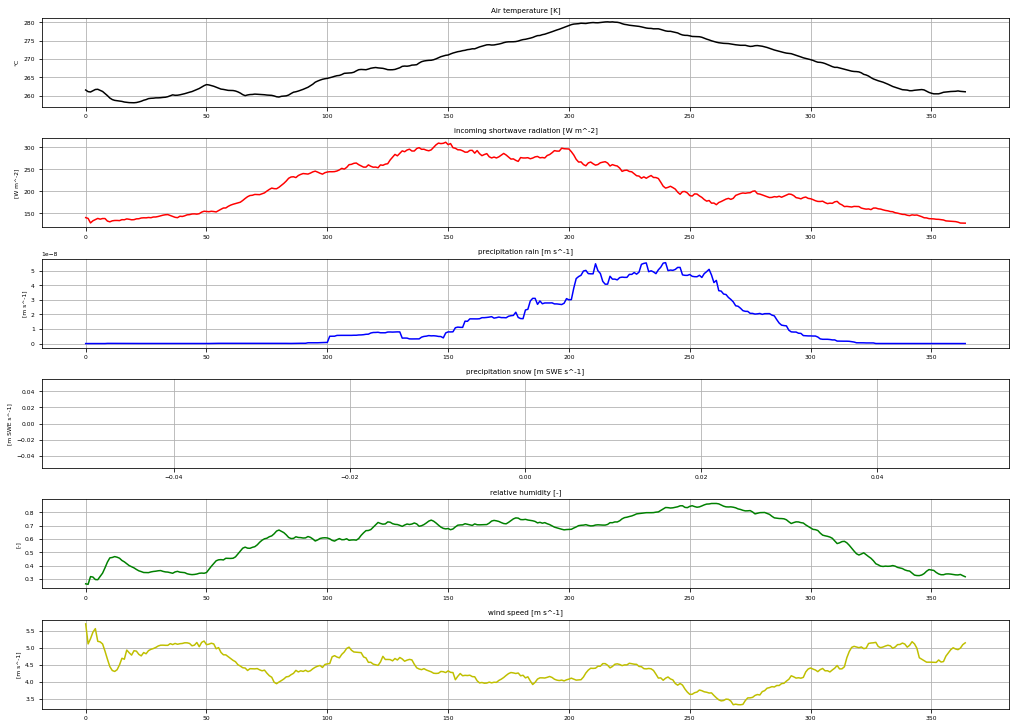

In [96]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=6, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])
f2_ax6 = fig2.add_subplot(spec2[5, 0])

f2_ax1.set_title('Air temperature [K]')
f2_ax1.plot(air_temp_smoothened,'k', label='Air temperature [K]')
f2_ax1.set_ylabel('°C')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('incoming shortwave radiation [W m^-2]')
f2_ax2.plot(incoming_SW,'r', label='incoming shortwave radiation [W m^-2]')
f2_ax2.set_ylabel('[W m^-2]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax2.grid(True)

f2_ax3.set_title('precipitation rain [m s^-1]')
f2_ax3.plot(prep,'b', label='precipitation rain [m s^-1]')
f2_ax3.set_ylabel('[m s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax3.grid(True)

f2_ax4.set_title('precipitation snow [m SWE s^-1]')
f2_ax4.plot(snow,'b', label='precipitation snow [m SWE s^-1]')
f2_ax4.set_ylabel('[m SWE s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax4.grid(True)

f2_ax5.set_title('relative humidity [-]')
f2_ax5.plot(rel_humid,'g', label='relative humidity [-]')
f2_ax5.set_ylabel('[-]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax5.grid(True)

f2_ax6.set_title('wind speed [m s^-1]')
f2_ax6.plot(wind_speed_10m,'y', label='wind speed [m s^-1]')
f2_ax6.set_ylabel('[m s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax6.grid(True)

1. Checks to be done:

a. Check ats input file - .xml file
    
b. TEMPCHEK - To check the template file
    
c. INSCHEK - To check the instruction file
    
d. Converting the file to version 1
    
e. PESTCHEK - To check the pest control file

In [87]:
# Testing subprocess
subprocess.check_output(['ls', '-l'])

b'total 1008\n-rw-rw-r-- 1 rk rk   2705 Nov 29 16:11 ats_modelcmd.py\n-rw-rw-r-- 1 rk rk   1712 Nov 29 15:47 Case1_B_glm_par_data.csv\n-rw-rw-r-- 1 rk rk    995 Nov 29 15:47 Case1_B_glm_pargrp_data.csv\n-rw-rw-r-- 1 rk rk  53901 Nov 29 15:47 Case1_B_glm.xml\n-rw-rw-r-- 1 rk rk  53913 Nov 29 16:06 Case1_B_glm.xml.tpl\n-rw-rw-r-- 1 rk rk     79 Nov 29 15:52 Case5_I_E_glm.insfile.csv\n-rw-rw-r-- 1 rk rk 303614 Nov 29 15:44 Case5_I_E_glm_obs_data.csv\n-rw-rw-r-- 1 rk rk  85337 Nov 29 15:47 Case5_I_E_glm_obs_data.dat.ins\n-rw-rw-r-- 1 rk rk   2075 Nov 29 15:25 Case5_I_E_glm_par_data.csv\n-rw-rw-r-- 1 rk rk   1277 Nov 29 15:20 Case5_I_E_glm_pargrp_data.csv\n-rw-rw-r-- 1 rk rk     61 Nov 29 15:53 Case5_I_E_glm.tplfile.csv\n-rw-rw-r-- 1 rk rk  92093 Nov 29 15:56 Case5_I_E.xml\n-rw-rw-r-- 1 rk rk  92049 Nov 29 16:08 Case5_I_E.xml.tpl\n-rw-rw-r-- 1 rk rk 304141 Nov 29 15:45 rk_model_glm_obs_data.csv\n'

In [88]:
### Running ats within a temp folder

subprocess.run(['mkdir','test_ats.demo'], capture_output=True, text=True).stdout

''

In [89]:
os.chdir('test_ats.demo')

In [91]:
file_name

'Case5_I_E_glm'

In [90]:
os.system(f'ats --xml_file=../{file_name}.xml')
# Run it in the terminal - easier to debug if there are errors

256

In [6]:
os.getcwd()

/home/rk/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/home/rk/pestpp/pestpp/rk_model_final'

In [10]:
### Checking the outputs
sim_data = pd.read_csv('test_ats.demo/observation.dat',skiprows=100,sep=' ')
sim_data.index

RangeIndex(start=0, stop=366, step=1)

Looks good!

#### Check the outputs in the file and also the jupyter notebook terminal - weather it is running. If all is good you can start with the pestcheck!

In [11]:
os.chdir('..')

In [12]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final'

In [13]:
os.chdir(directory_name)

### Check the file name and line for finding porosity of peat and mineral

In [18]:
import re

In [40]:
# 1. To find the porosity
filename = f'Case5_I_E_glm.xml'
line_por_peat = 602 # 
line_por_mineral = 611

with open(f'{filename}') as oldfile:
            for line, content in enumerate(oldfile):
                if line == line_por_peat: # Line 603 (+1) has the porosity_peat 
                    poro_peat_line = str(content)
                    result = re.findall('\".*?\"', poro_peat_line)
                    #poro_peat = float(result[2].replace('"',''))
                    print(poro_peat)
                elif line == line_por_mineral: # Line 612 (+1) has the porosity_mineral
                    poro_mineral_line = str(content)
                    result_2 = re.findall('\".*?\"', poro_mineral_line)
                    poro_mineral = float(result_2[2].replace('"',''))
                    print(poro_mineral)

0.63739496
0.48103077


In [41]:
### Check the ats_modelcmd.py file - Change the file name if required!
os.system('python3 ats_modelcmd.py')
### Make sure that the observation file is created!

0

In [98]:
# Running tempchek
subprocess.run(['tempchek'], capture_output=True, text=True).stdout

' TEMPCHEK Version 17.3. Watermark Numerical Computing.\n\n TEMPCHEK is run using the command:\n\n    tempchek tempfile [modfile [parfile]]\n\n where\n\n    "tempfile" is a PEST template file,\n    "modfile" is an [optional] model input file to be written by TEMPCHEK, and\n    "parfile" is an [optional] parameter value file.\n\n'

In [99]:
# Running tempchek
subprocess.run(['tempchek',f'{file_name}.xml.tpl'], capture_output=True, text=True).stdout

' TEMPCHEK Version 17.3. Watermark Numerical Computing.\n\n Errors in file Case5_I_E_glm.xml.tpl ----->\n No errors encountered.\n\n 26 parameters identified in file Case5_I_E_glm.xml.tpl: these are listed in \n   file Case5_I_E_glm.xml.pmt.\n\n'

In [100]:
# Running inschek
subprocess.run(['inschek',f'{file_name}_obs_data.dat.ins'], capture_output=True, text=True).stdout

' INSCHEK Version 17.3. Watermark Numerical Computing.\n\n Errors in file Case5_I_E_glm_obs_data.dat.ins ----->\n No errors encountered.\n\n 5110 observations identified in file Case5_I_E_glm_obs_data.dat.ins: these \n   are listed in file Case5_I_E_glm_obs_data.dat.obf.\n\n'

In [139]:
### Converting the pest control file to version 1

In [101]:
import pyemu

In [102]:
directory_name

'Case5_I_E_glm_start.demo'

In [103]:
pst = pyemu.Pst(f"{file_name}_cf.pst")
pst.write(f"{file_name}_cf_v1.pst")

noptmax:-1, npar_adj:26, nnz_obs:5110


In [104]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final/Case5_I_E_glm_start.demo'

In [105]:
### Checking the pest control file once more

subprocess.run(['pestchek',f"{file_name}_cf_v1.pst"], capture_output=True, text=True).stdout

' PESTCHEK Version 17.3. Watermark Numerical Computing.\n\n Errors ----->\n No errors encountered.\n\n Warnings ----->\n It appears that the PEST control file contains a "rsi" section. PESTCHEK did \n   not check this. It can only be used by RSI_HP.\n NUMLAM is supplied as negative. This will be reset to positive. If Parallel \n   PEST or BEOPEST is used PARLAM will automatically be set to -9999.\n NOPTMAX provided as -1. No optimisation will be carried out; objective \n   function, residuals and statistics will be recorded for initial parameter \n   estimates only.\n MAXSING in the singular value decomposition section is greater than the \n   number of adjustable parameters.\n'

* If the error of DERCOM appears - Just remove 1 from the all the par_data lines!

#### Change the file name in 'ats_modelcmd.py' to pest file name

In [106]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final/Case5_I_E_glm_start.demo'

In [42]:
### Running pest file

os.system(f'pest {file_name}_cf_v1.pst')
#subprocess.run(['pest',f'{file_name}_cf_v1.pst','&>out.log'], capture_output=True, text=True).stdout

2

### Reweighting strategy - PWTADJ1


In [154]:
subprocess.run(['pwtadj1'], capture_output=True, text=True).stdout

'\n PWTADJ1 version 17.3. Watermark Numerical Computing.\n\n PWTADJ1 is run using the command:\n\n     pwtadj1 casename pestoutfile contribution\n\n where\n\n     casename     is an existing PEST casename,\n     pestoutfile  is the name of a new PEST control file, and \n     contribution is the new objective function for each observation group.\n'

### Check the total objective function value in the .rec file and add in the cmd below:

In [99]:
obj_fn_value = 1.07725E-02 # Taken from .rec file

In [100]:
subprocess.run(['pwtadj1',f'{file_name}_cf_v1.pst',f'{file_name}_cf_v1_rw.pst',f'{obj_fn_value/2}'], capture_output=True, text=True).stdout

'\n PWTADJ1 version 17.3. Watermark Numerical Computing.\n\n - reading PEST control file Case1_B_glm_cf_v1.pst for first time...\n - file Case1_B_glm_cf_v1.pst read ok.\n\n - reading PEST run record file Case1_B_glm_cf_v1.rec...\n - file Case1_B_glm_cf_v1.rec read ok.\n\n - re-reading file Case1_B_glm_cf_v1.pst and writing file Case1_B_glm_cf_v1_rw.pst...\n - file Case1_B_glm_cf_v1.pst read ok.\n - file Case1_B_glm_cf_v1_rw.pst written ok.\n'

In [101]:
# Removing the out.log file since it's file size is large
subprocess.run(['rm','-rf','out.log'], capture_output=True, text=True).stdout

''

In [102]:
os.chdir(f'..')

In [103]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final'

In [9]:
directory_name_rw = f'{file_name}_rw.demo'

In [105]:
directory_name

'Case1_B_start.demo'

In [106]:
# Copying the files to a new folder
shutil.copytree(directory_name, directory_name_rw)

'Case1_B_glm_rw.demo'

In [10]:
os.chdir(f'{directory_name_rw}')

In [11]:
cf_name = f'{file_name}_cf_v1' # Control file name befor reweighting

In [12]:
# Removing unnecessary files to provide space for the simulation
# Check once more if all the files have been removed properly
os.system(f'rm {cf_name}.drf {cf_name}.jac {cf_name}.jst {cf_name}.jco {cf_name}.mtt {cf_name}.par {cf_name}.rec {cf_name}.rei {cf_name}.res {cf_name}.sen {cf_name}.seo {cf_name}.svd {cf_name}.rst jacob.runs')

256

In [13]:
file_name

'Case1_B_glm'

In [ ]:
# Running the new re-weighted pest file
os.system(f'pestpp-glm {file_name}_cf_v1_rw.pst')
# Prefer running it on the terminal?